Plans for this Document:

### Term Counting Approach

* to count products...
* use a pre trained library, for example glove? and detect all words which are close to the original ones.
    * pretrained wont be good, but we can train our own model and then check if that is worthwhile.
* PER POST (IN A THREAD)
* to count hazards...
* for basic contaminants we can use pre trained library.
* for the others we can just search them specificall (for example bisphenol, or others which have very unique words.)
    * optional extra step: use somethign which will find typos of it. (related to word distance calculator things. but this will take much longer time to process)
   

In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

In [4]:
with open('/Users/sma/Documents/INRAE internship/scrape-git/facebook/untypod_dict.pkl', 'rb') as f:
    netmums = pk.load(f)

#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/allposts_rerun.pkl', 'rb') as f:
#    netmums = pk.load(f)
    
#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/netmums_subset_keys.txt', 'r') as f:
#    keys = [url.strip() for url in f.readlines()]
        

In [5]:
#  #netmums
nm_ind = indicators.indicators(netmums, fb=False)
#  #this one takes long, around 20 seconds I think.

posts_dict = nm_ind.get_posts_dict()

In [6]:
hazards = {
'Chemical contaminants': [],
'Endocrine disruptor': ["endocrine","estrogen"],
'FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES':["preservatives","sweeteners","additives"],
"Pesticides":[],
"Veterinary drugs":["animal drugs","vet drugs"],
'GMO':['GM',"genetically modified"],
"Metals":[],
"Mycotoxin":[],
"Bisphenol A":['BPA','Bisphenol','BisphenolA'],
'Furan':[],
'DON': #(note that this acronym nobody uses and all results are from words like "don't")
["deoxynivalenol",
"vomitoxin"],
'DIOXIN AND PCB':["Dioxin","PCB","biphenyls"],
'MOSH and MOAH':["hydrocarbons","saturated hydrocarbons","MOAH", 'MOH',"aromatic hydrocarbons"],
'Nitrates':[],
"Acrylamid":["Acrylamide"],
"phthalates":[],
"Microbiologic contaminants":
["spores",
"mold",
"mould",
"virus",
"microbes",
"contaminated"],
"Salmonella":[],
"Campylobacter":[],
"Listeria":[],
"EColi":["E-coli"],
"Cronobacter":[],
"Histamine":[],
'other bacteria':["bacteria"],
"Virus":[],
"Parasites":[],
'Related Terms':["carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]
}

products = {
'infant formula':
["formula","baby formula", "bottle-fed", "bottle"]
,'sterilized vegetable mixed with fish':
["veggie baby food","vegetable baby food",
"veg puree", "veg purée"]
,'fresh fruit puree mildly processed':
["fruit puree","fruit baby food", "fruit purée", "applesauce", "apple sauce", "fruit sauce"]
,'infant cereals':
["cereal for baby", "cereal", "porridge", "oats", "oatmeal"]
,'other':
["jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]
}


#IMPORTANT!: terms used for count vectorizer must be lower-case o.w. get 0 matches
hazards = {key.lower():[v.lower() for v in value] + [key.lower()] for key,value in hazards.items()}
products = {key.lower():[v.lower() for v in value]+[key.lower()] for key,value in products.items()}

In [7]:

extras = {\
'baby_food_brands':
['ellas',
'organix',
'heinz baby',
"plum baby",
'little angels',
'farleys'],
'formula_brands':['sma','aptamil comfort','infasoy','nutramigen','neocate','powdered milk','comfort milk'],
 'food_or_formula_brands':
['aptamil', # formula and cereals.
'hipp organic',# - formula and baby food
'cow gate','cow and gate','c g',
'mamia'],
##NON BRAND SIGNALS##
'cereal':['baby_cereal','baby riceporridge','baby rice','baby porridge'],
'baby_food':['mashed','tinned','premade','canned','jarred','pouches','pouch','ready made','readymade','cartons'],  
#INDICATORS TO BE USED IN CONJUNCTION WITH 'baby food' label: this way we 
#can observe if both terms are used in a document (but are not used right next to each other.)
'fruit':['fruit'],
'vegetable':['vegetable'],
'baby':['infant', 'baby' ,'for littles']
         }


In [8]:
import re

def make_phrases(list_of_phrases, text):
    """
    convert phrases to bigrams within a larger text corpus.
    example: "I love collard greens for breakfast" -> "I love collard_greens for breakfast"
    example: "I love collard-greens for breakfast" -> "I love collard_greens for breakfast"
    """
    for phrase in list_of_phrases:
        #spaces
        text = re.sub(phrase, re.sub(' ', '_',phrase), text)
        #hyphens
        text = re.sub(re.sub(' ', '-', phrase), re.sub(' ', '_',phrase), text)
    return text

def make_underscores(item):
    """
    recursively replace spaces and hyphens in strings, lists, sets, or other iterables.
    Return the same type if string, list, set. If other type, returns list.
    """
    if type(item) is str:
        return re.sub(' |-', '_', item)
    else:
        temp = []
        for thing in item:
            temp.append(make_underscores(thing))
    if type(item) is set:
        return set(temp)
    elif type(item) is list:
        return temp
    elif isinstance(item, type({}.keys())):
        #if the object is a dict.key() view
        return temp
    else:
        print('Object must be string, list, set, or dict.keys()')
    #TODO this would be cleaner if i just check that it's iterable, and then check that it's a string.

In [9]:
#from the dict which representes our subcategories, create lists of all words in the subcategories.
h = [item for val in hazards.values() for item in val]
p = [item for val in products.values() for item in val]
e = [item for val in extras.values() for item in val]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#TODO: EXPLAIN!
phrases = {'baby formula', 'baby cereal'}.union({item for item in p + h + e if ' ' in item})

#step 1: make a dict of just the text
text_dict = {key:value['body'] for key,value in posts_dict.items()}

#step 2 : convert the relevant phrases to bigrams with re.sub
text_dict = {key: make_phrases(phrases, text) for key, text in text_dict.items()}

#replace "don't" with "do not" (so that we don't get false positives for don count.)
for key in text_dict:
    text_dict[key] = re.sub('don[\W]+t', 'do not', text_dict[key], flags=re.I) #TODO. there are cases of "don' " need to catch.

#step 3: count occurences using countvectorizer
vocab = p + h + e
vocab = [re.sub(' |-','_',item) for item in vocab] #should I use make_underscores instead??
vocab = set(vocab)
term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
counts = term_counter.fit_transform(text_dict.values())

#note that hyphens will be treated as spaces by countvectorizer

In [11]:
counts = counts.toarray() #run once
count_dict = {}
for num, key in enumerate(text_dict.keys()): #TODO just use netmums, not text_dict?? its confusing.
    #dict of 'term':count for each document
    #FIXME: UNCLEAR this is unclear due to using "key", twice. the key in the set corresponds to term_counter,
    # the key in the for loop  and count_dict[] is from text_dict
    count_dict[key] = {key: counts[num][value] for key, value in term_counter.vocabulary_.items()}

In [12]:
countdf = pd.DataFrame.from_dict(count_dict).transpose()
countdf

acrylamid  acrylamide  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0           0   
                                                   1          0           0   
                                                   2          0           0   
                                                   3          0           0   
                                                   4          0           0   
...                                                         ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0           0   
                                                   6          0           0   
                                                   7          0           0   
                                                   8          0           0   
                                                   9          0           0   

                                                      additives  animal_drugs  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0             0   
                                                   1          0             0   
                                                   2          0             0   
                                                   3          0             0   
                                                   4          0             0   
...                                                         ...           ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0             0   
                                                   6          0             0   
                                                   7          0             0   
                                                   8          0             0   
                                                   9          0             0   

                                                      apple_sauce  applesauce  \
https://www.netmums.com/coffeehouse/becoming-mu... 0            0           0   
                                                   1            0           0   
                                                   2            0           0   
                                                   3            0           0   
                                                   4            0           0   
...                                                           ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5            0           0   
                                                   6            0           0   
                                                   7            0           0   
                                                   8            0           0   
                                                   9            0           0   

                                                      aptamil  \
https://www.netmums.com/coffeehouse/becoming-mu... 0        0   
                                                   1        0   
                                                   2        0   
                                                   3        0   
                                                   4        0   
...                                                       ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5        0   
                                                   6        0   
                                                   7        0   
                                                   8        0   
                                                   9        0   

                                                      aptamil_comfort  \
https://www.netmums.com/coffeehouse/becoming-mu... 0                0   
                                                   1                0   
                                                   2                0   
                                                   3                0   
             

### Meta: Check if our groupings of hazard terms are good..

if terms are highly correlated with unrelated terms this could be bad.
if terms are indepndent of their related terms thsi is not bad, it means they are finding extra posts.
if terms are correlated with tehir related terms this is not bad and indicates the terms are used in the same post.

<AxesSubplot:>

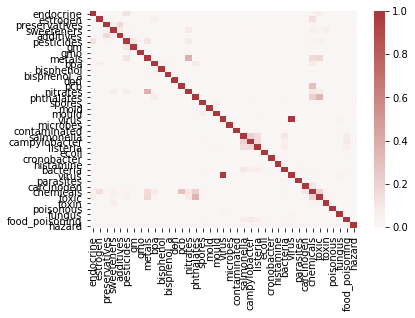

In [47]:
sns.heatmap(countdf[make_underscores(h)].corr().dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

In [15]:
summed_df = pd.DataFrame()

for key in products.keys():
    summed_df[key] = countdf[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_df[key] = countdf[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_df[key] = countdf[make_underscores(extras[key])].sum(axis=1)

### process the fruit, vegetable, baby columns

Idea: we only want to count mentions of fruit in the context of baby food. So we take the count of fruit and multiply it by the whether the mentions of baby are non-zero or not.

In [69]:
#count mentions of fruit or vegetable
#return 0 if there is no words indicating a context of BABY foods (not adult foods)
#note that baby food brand names occur much more than fruit or veg. Am not sure if they co-occur.
#TODO: maybe it is better to add the brands in with the fruit / veg. But since it is highly corr with them alreayd, at least looking by post it isnt a problem
summed_df['fruit_in_baby_context'] = summed_df['fruit']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)
summed_df['veg_in_baby_context'] = summed_df['vegetable']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

#if there is mention of fruit or vegetable it's not uncategorized. return 0
# if no mentions, sum the counts of mentions of baby food brands
# possible improvement: check for words indicating a food, or in weaning forum etc. THEN we can also add food_or_formula_brands to the COUNT.
summed_df['baby_food_uncategorized'] = (summed_df[['fruit','vegetable']].sum(axis=1) > 0) * summed_df['baby_food_brands']

In [70]:
class_df = summed_df.copy()

In [73]:
product_cols = list(products.keys()) + ['veg_in_baby_context', 'fruit_in_baby_context', 'baby_food_uncategorized']

In [74]:
#classify
class_df['product_type'] = class_df[product_cols].idxmax(axis=1).astype('category')

# Check the Resulting Totals

## Total Count

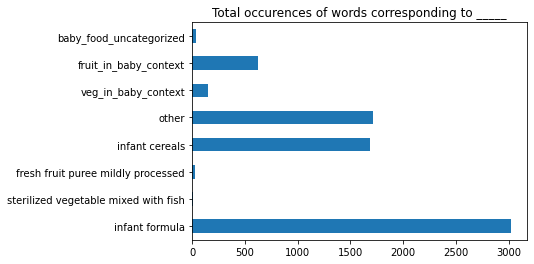

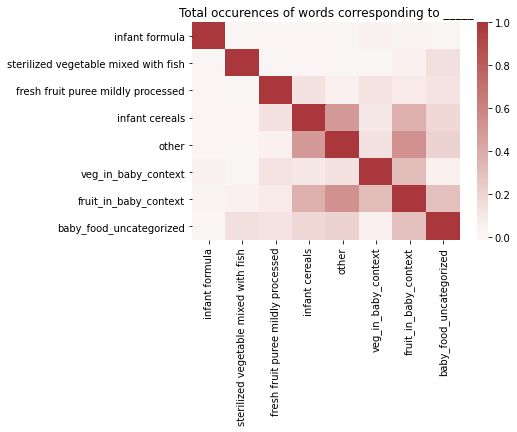

In [77]:
class_df[product_cols].sum(axis=0).plot(kind='barh')
plt.title('Total occurences of words corresponding to _____')
plt.show()
sns.heatmap(class_df[product_cols].corr(), cmap= "vlag", center=0.00)
plt.title('Total occurences of words corresponding to _____')
plt.show()

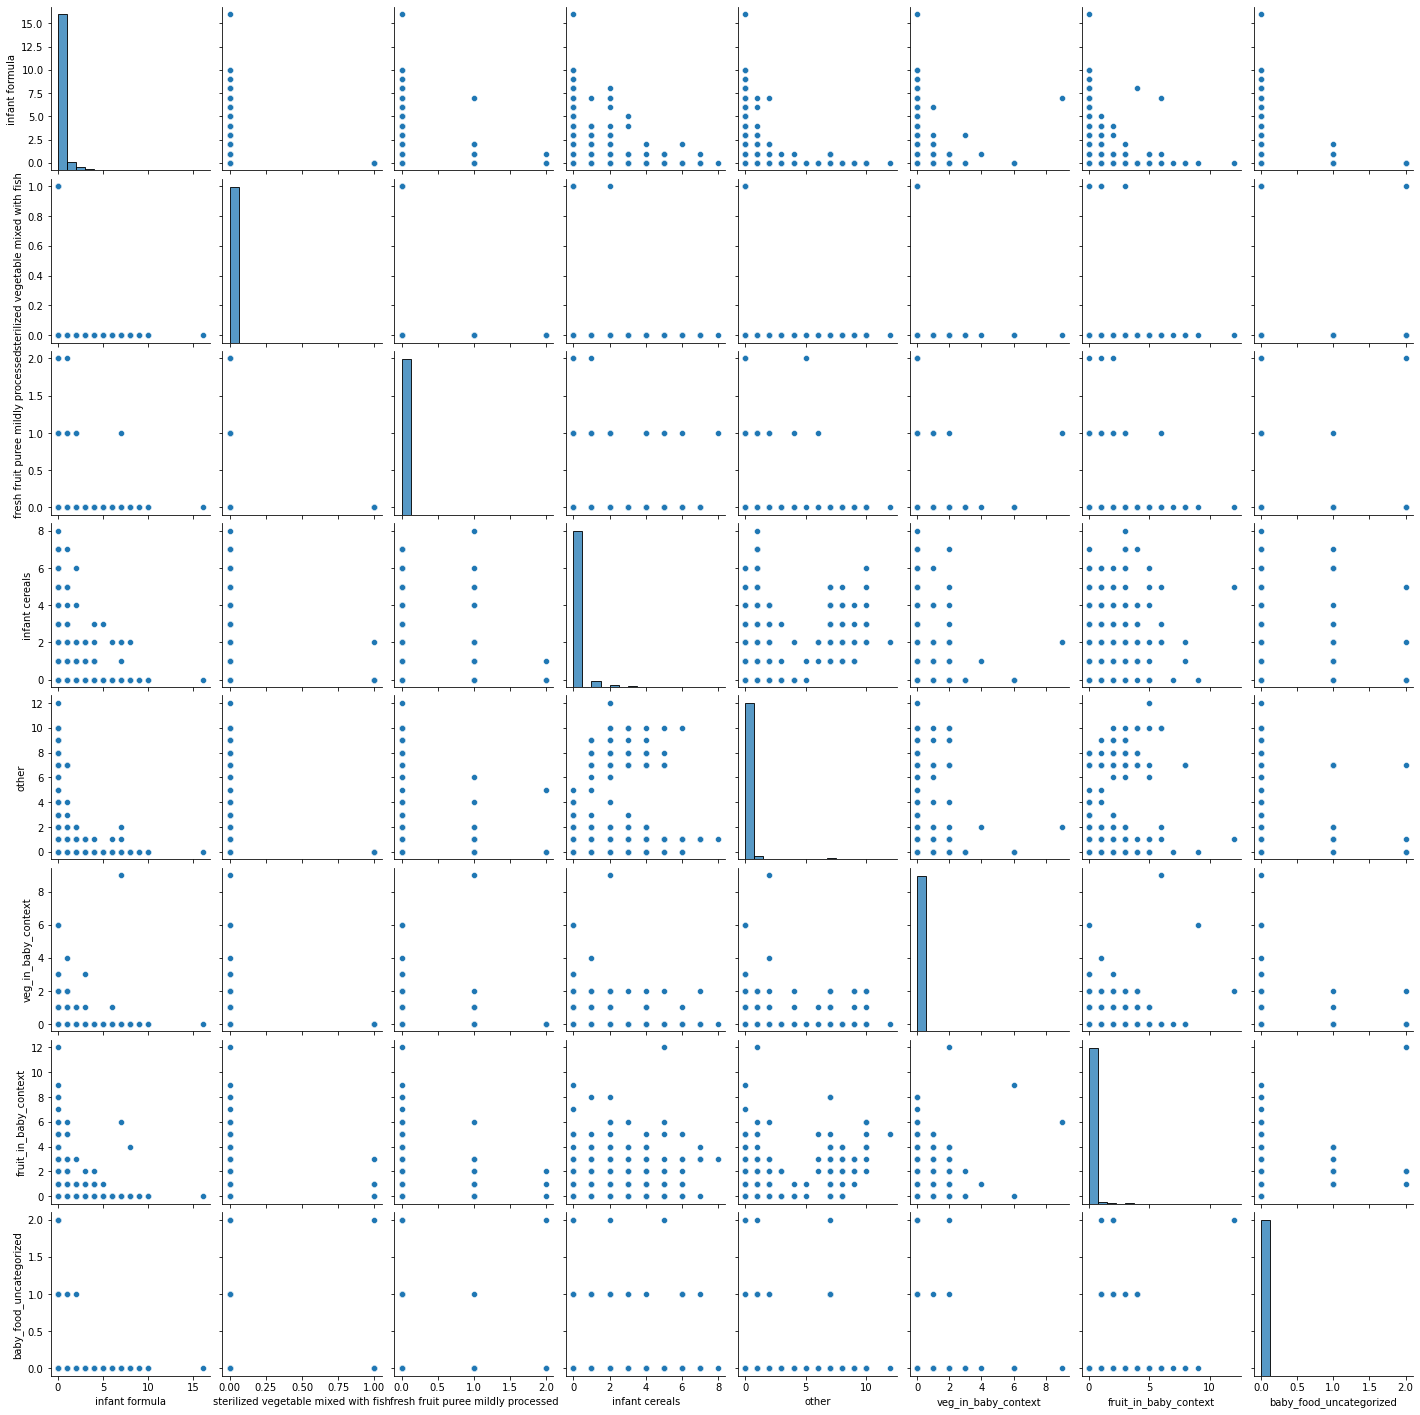

In [78]:
sns.pairplot(class_df[product_cols])

## Number of Posts Containing an Occurence

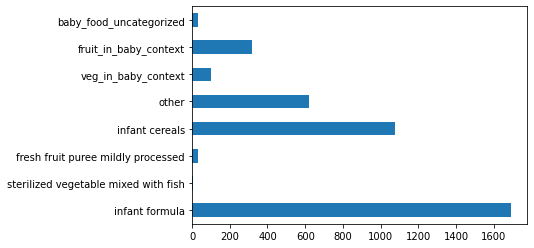

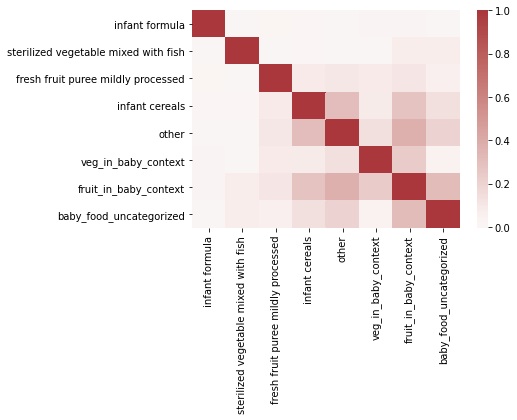

In [79]:
(class_df[product_cols] > 0).sum(axis=0).plot(kind='barh')
plt.show()
sns.heatmap((class_df[product_cols] > 0).corr(), cmap= "vlag", center=0.00)
plt.show()

# Check the Classification

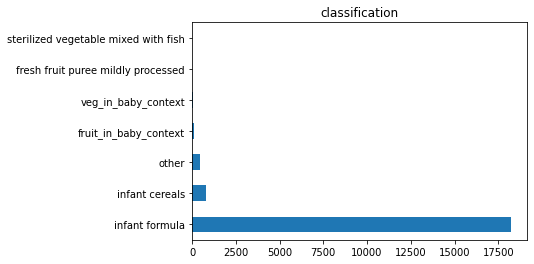

<AxesSubplot:title={'center':'classification (log scale)'}>

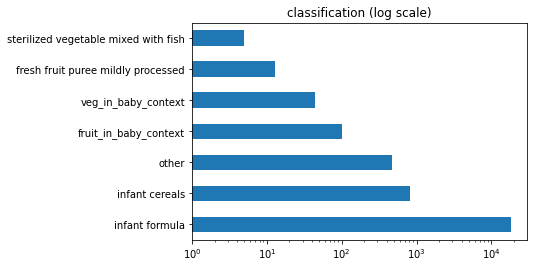

In [25]:
class_df['product_type'].value_counts().plot.barh(title = 'classification')
plt.show()

class_df['product_type'].value_counts().plot.barh(title='classification'+ ' (log scale)', log=True)

# Hazard Occurences by Product Class

## Number of Occurences

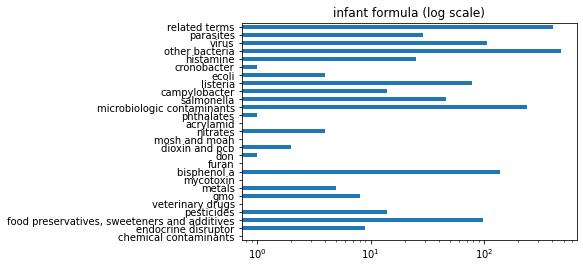

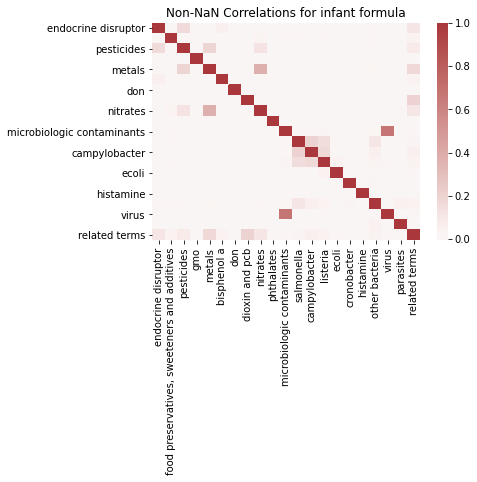

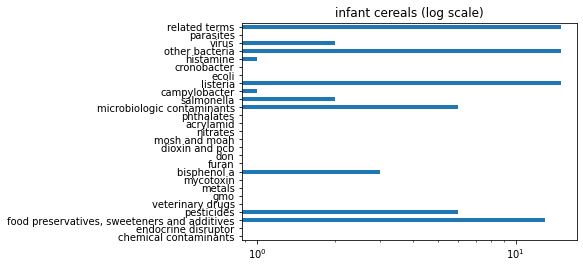

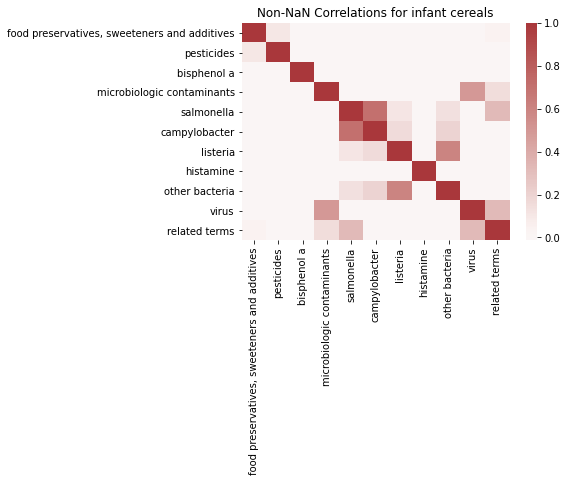

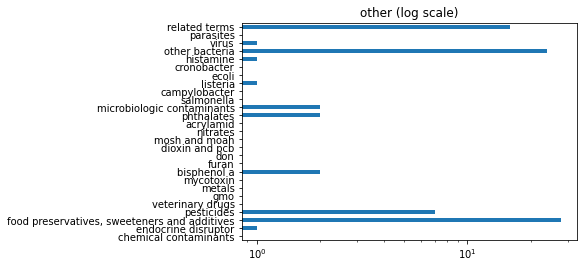

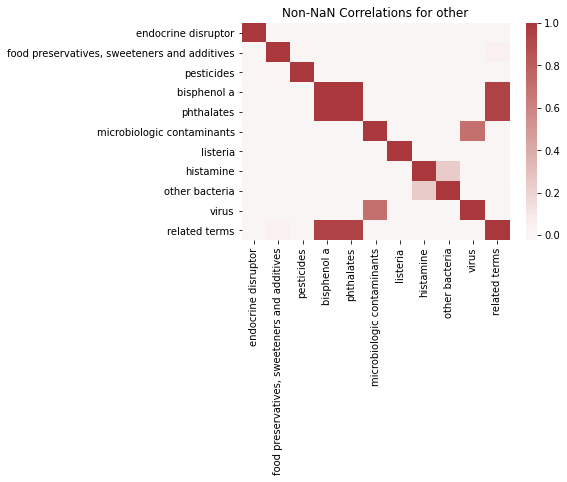

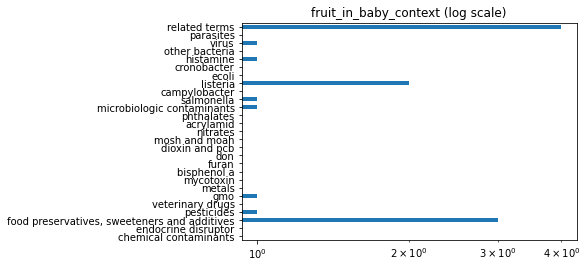

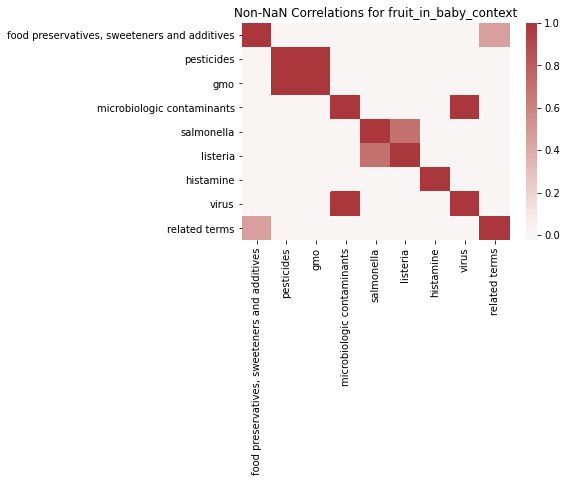

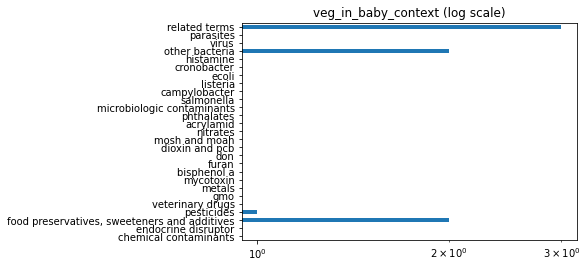

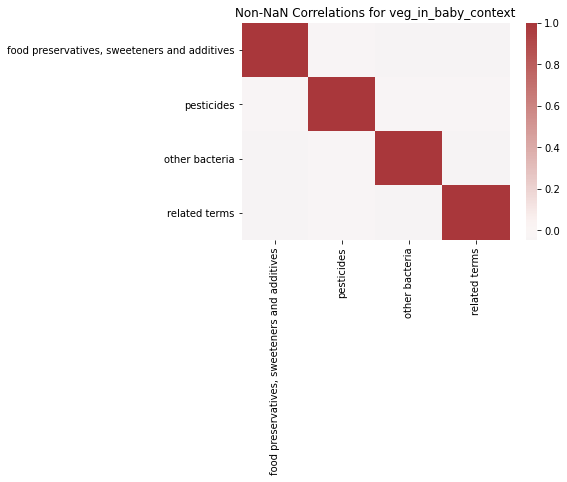

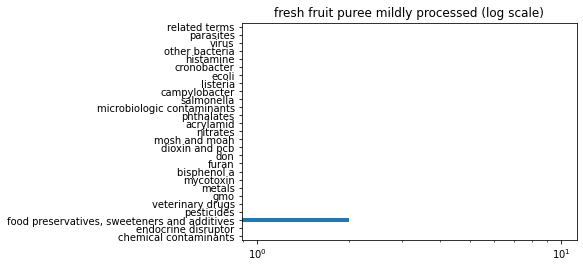

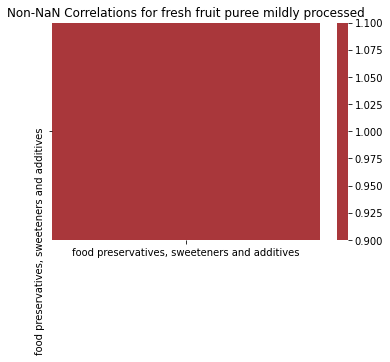

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


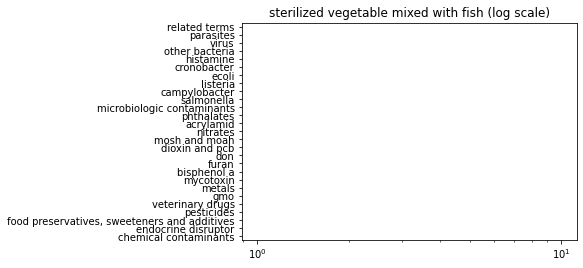

[insufficient data to render sterilized vegetable mixed with fish plot! ]


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


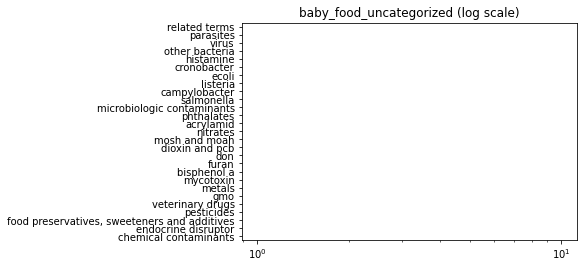

[insufficient data to render baby_food_uncategorized plot! ]


In [80]:
colormap = sns.color_palette("vlag", as_cmap=True)

for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        class_df.loc[class_df.product_type == category][hazards.keys()].sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = class_df.loc[class_df.product_type == category][hazards.keys()].corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap= colormap, center=0.00)
        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

## Number of Posts Containing and Occurence

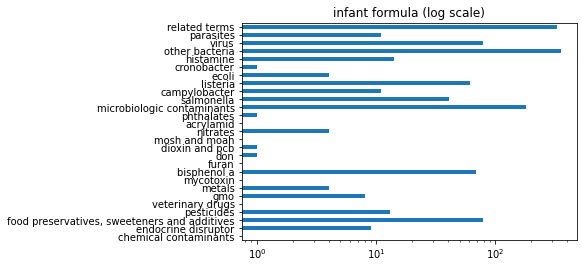

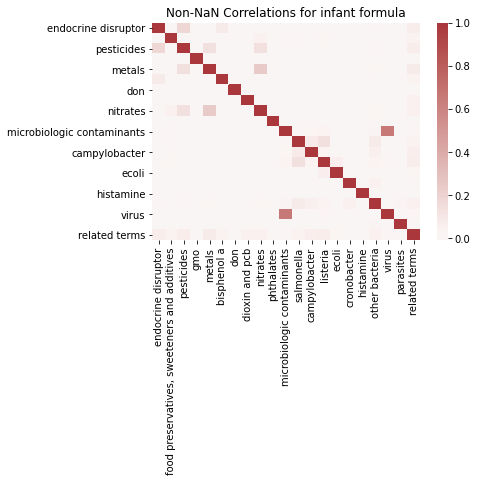

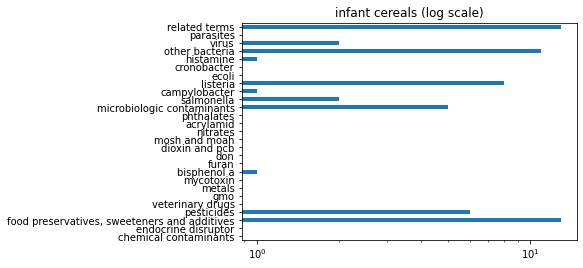

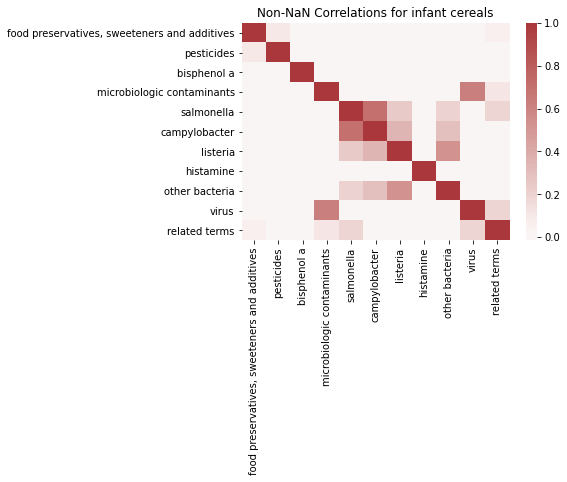

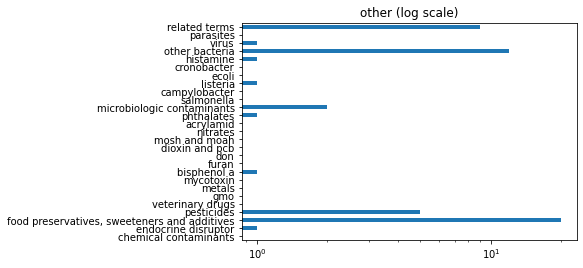

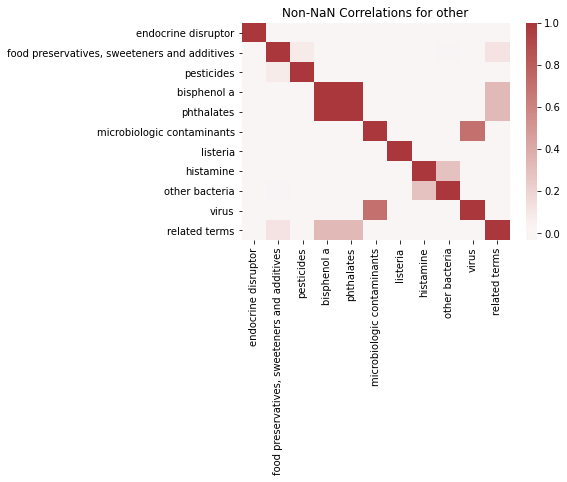

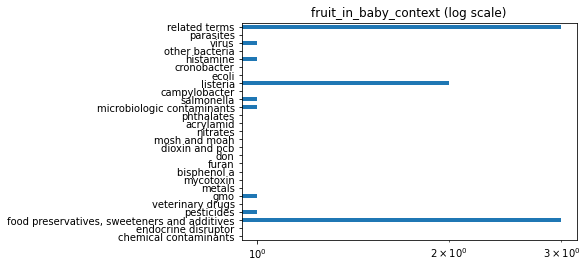

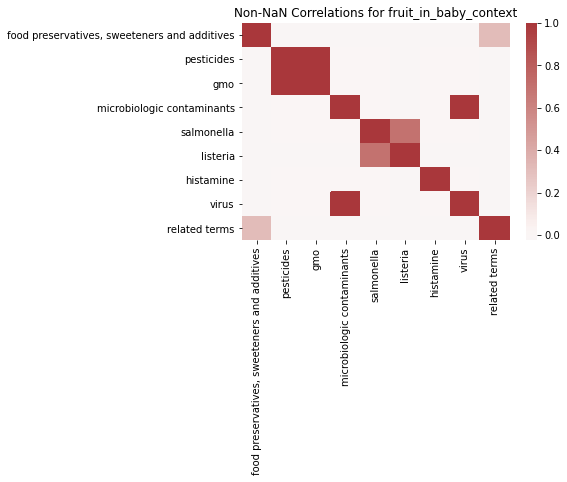

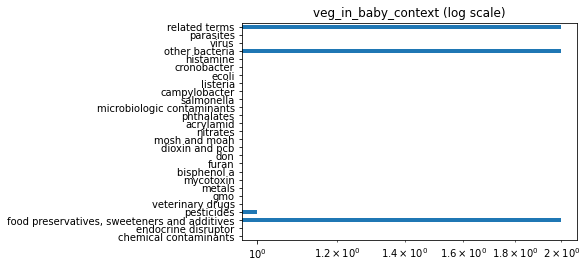

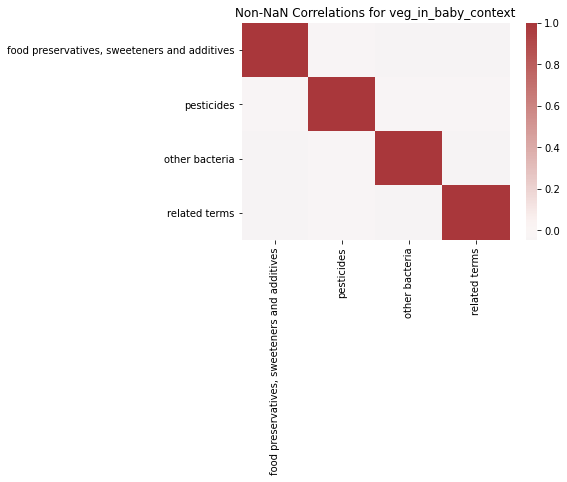

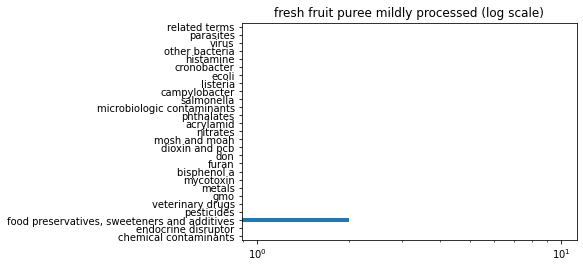

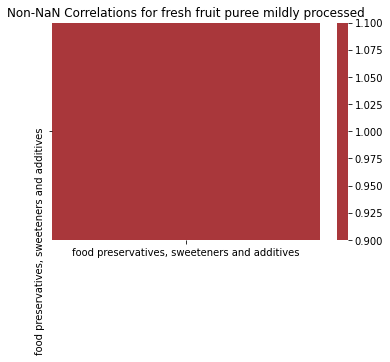

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


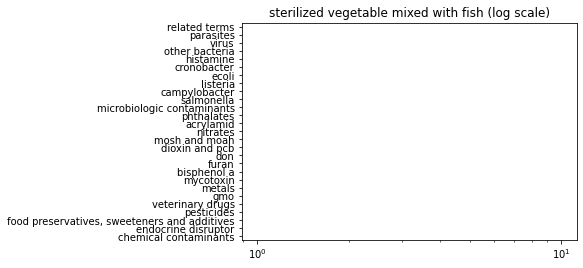

[insufficient data to render sterilized vegetable mixed with fish plot! ]


In [27]:
colormap = sns.color_palette("vlag", as_cmap=True)

for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    num_of_posts = class_df.loc[class_df.product_type == category][hazards.keys()] > 0
    
    try:
        num_of_posts.sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = num_of_posts.corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap=colormap, center=0.00)

        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

# Count of Users Mentioning Each set of Words  (OR SOMETHING??) (TODO)

In [28]:
#formula_classed = term_count_product_df.loc[term_count_product_df.labels == 'term_counts_formula'].index

In [29]:
#term_count_hazard_df.loc[term_count_product_df.labels == 'term_counts_formula'].sum(axis=0).plot.barh(figsize=(4,10))

In [30]:
#temp[0]

In [31]:
#DEBUGGING DON
temp = list(class_df[class_df.don > 0].index)
posts_dict[temp[1]]


IndexError: list index out of range

In [ ]:
len(temp)

# Running KNN on the processed numbers. (maybe) TODO 

# LDA Approach...

 how many possible cateorgires do we have?
 4 Products
 18 Hazards

 so we do
     * k = 4
     * k = 18
     * k = $18*4$ = 72


In [ ]:
#TODO: 
#we can try this approach at the post level and comment level.
# (IN ANOTHER JUPYTER NOTEBOOK)
